# Working with CM2.6

This is a supposed to be a 'real-life' science workflow example. No tiny well-behaved test cases. Instead you will see an approximation of how your science project could evolve, based on some of my experiences. The actual results do however not make a lot of sense, so there is still some work needed 😜. 

I will try to convey some core concepts that hopefully convince you of the awesomeness of **Analysis-Ready Cloud Optimized** (ARCO) data + flexible/scalable cloud computing:

- Quickly loading/exploring huge datasets without *downloading them*

- Analysis, scaled on demand, transitioning from exploration to heavy processing in minutes.

A quick primer on the LEAP-Pangeo infrastructure:

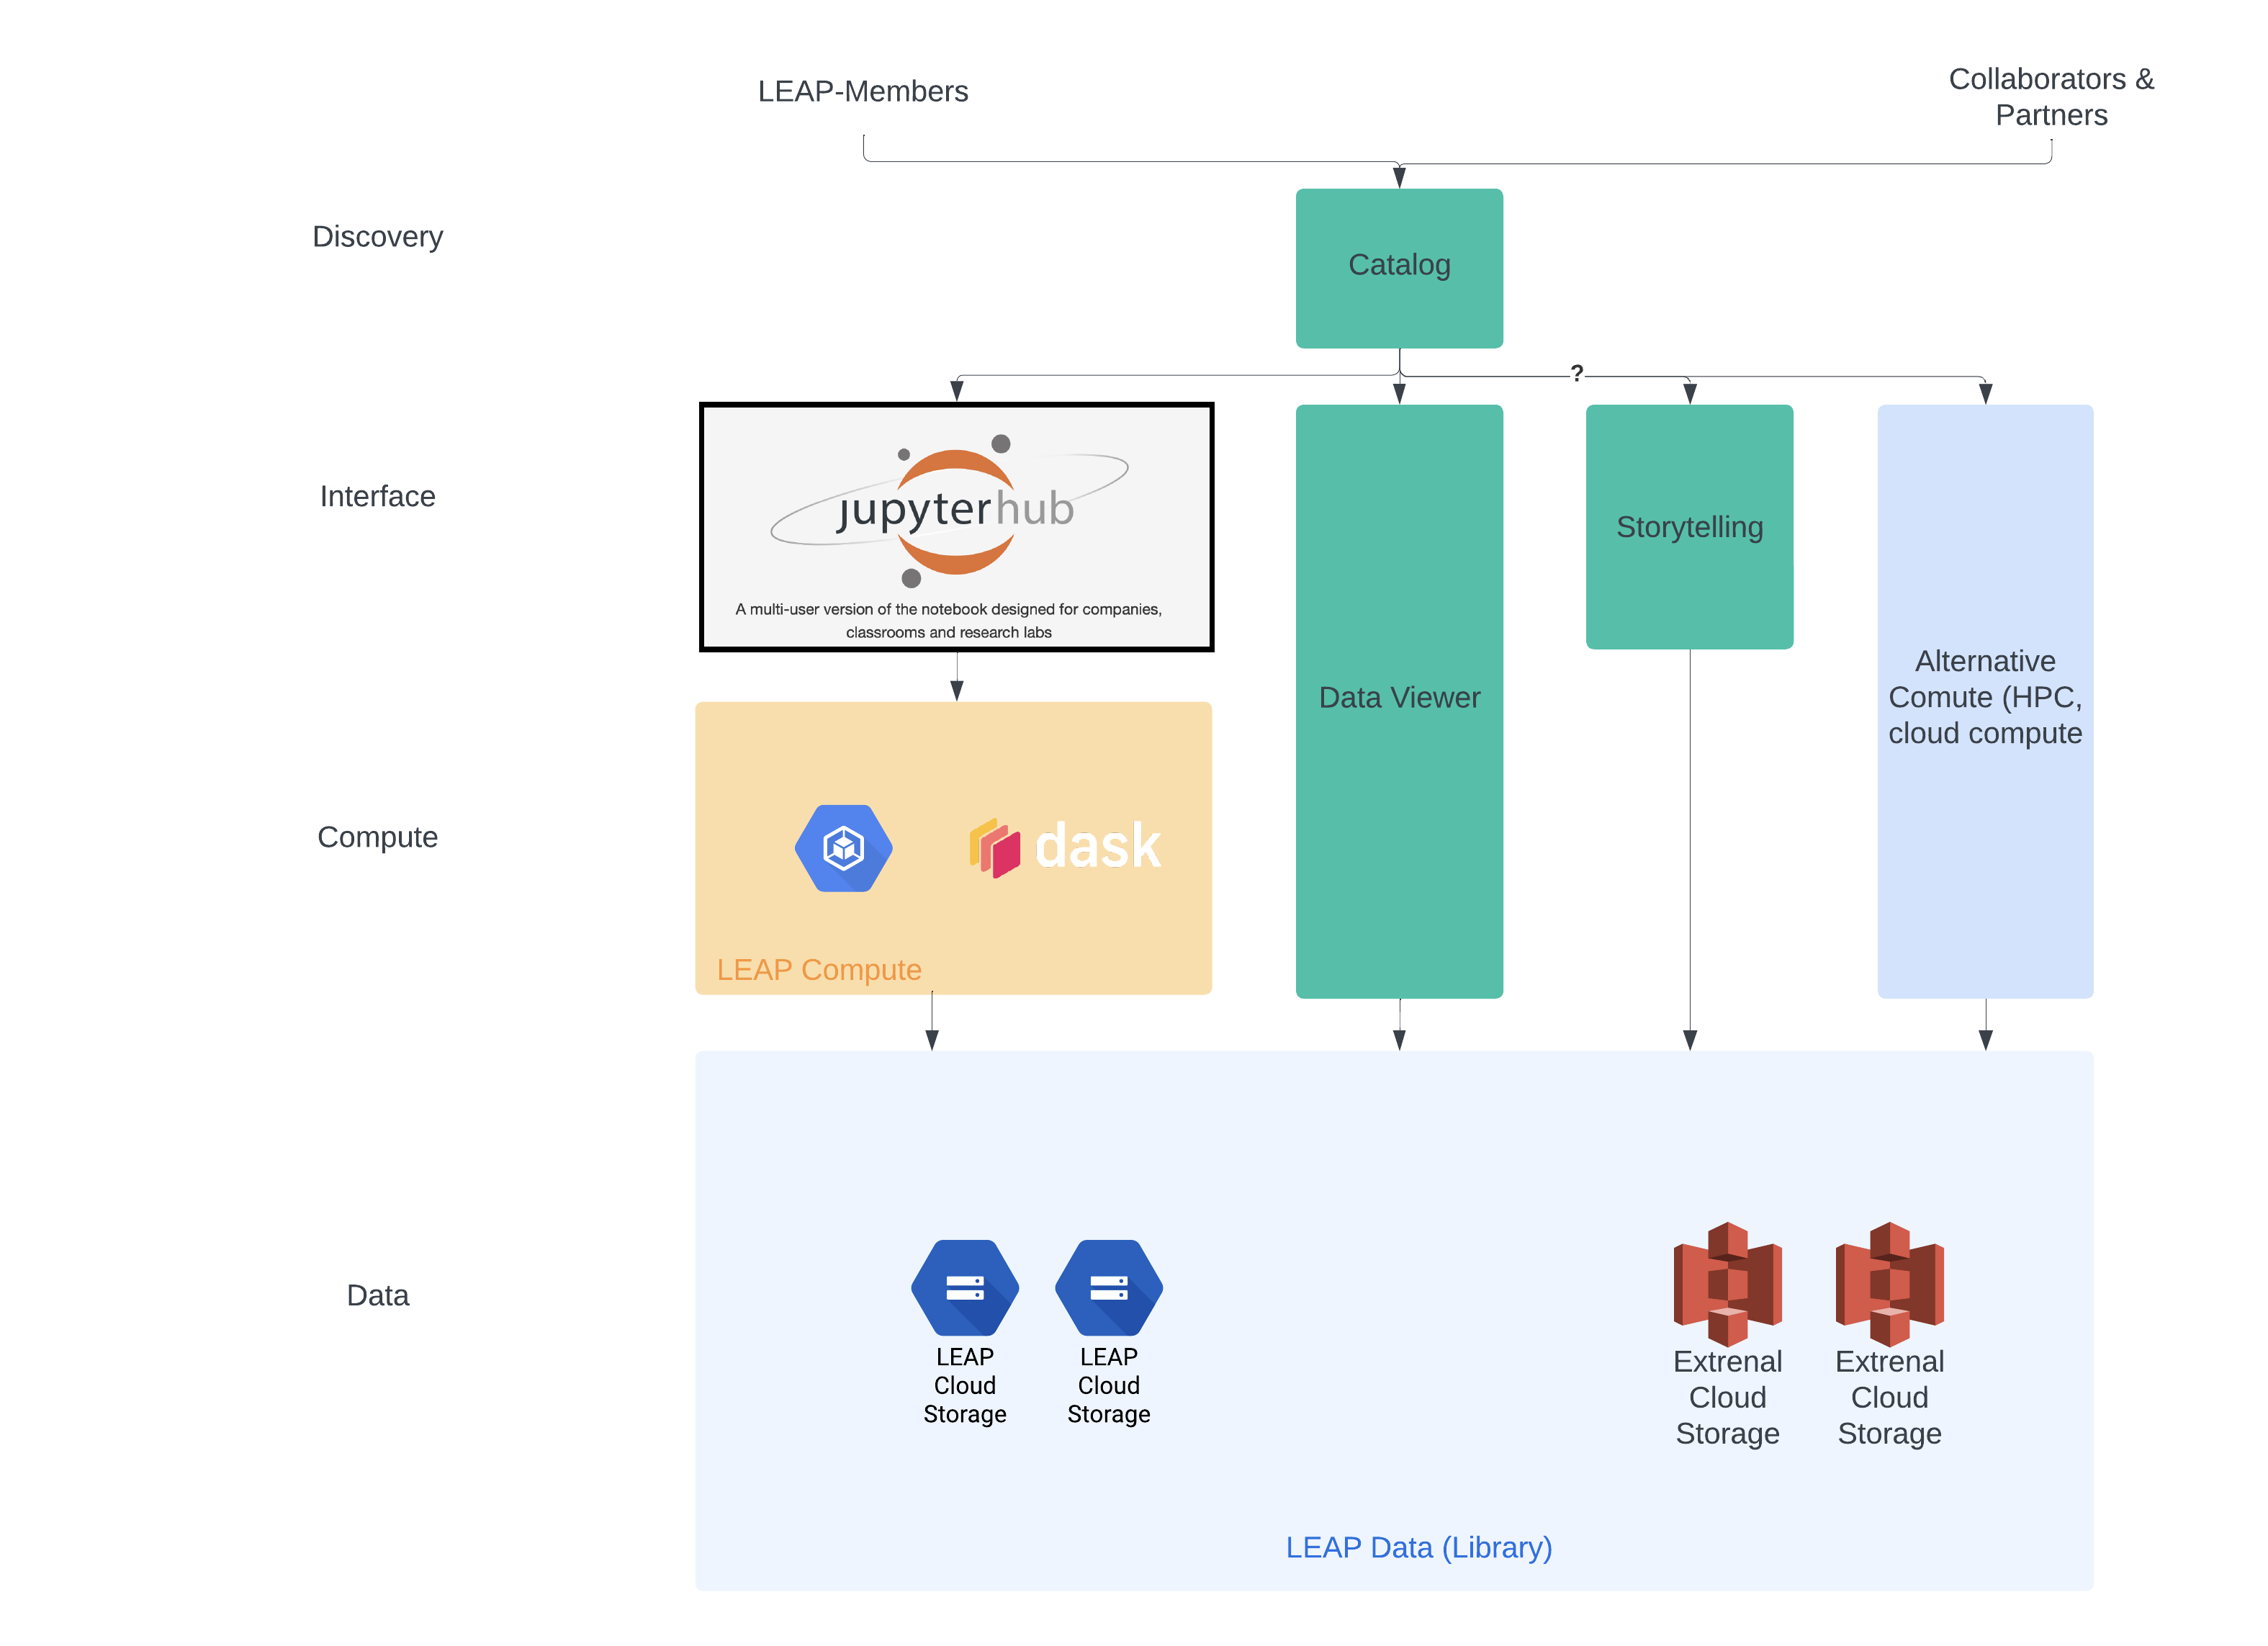

## What is ARCO data?

> "A “cloud-native data repository,” as defined in this article, offers several advantages over traditional data repositories - performance, reliability, cost-effectiveness, collaboration, reproducibility, creativity, downstream impacts, and access and inclusion."
[Abernathey et al. 2021](https://ieeexplore.ieee.org/document/9354557)


As an example I have chosen to work on the [NOAA-GFDL CM2.6 high resolution coupled climate simulation](https://www.gfdl.noaa.gov/high-resolution-climate-modeling/). 

## Where can I find CM2.6 data?
~~[LEAP-Pangeo Catalog](https://leap-data-catalog.vercel.app/)~~(not quite working yet, but will be soon!)
[PR](https://github.com/leap-stc/data-management/pull/50/files)


## How can I get my own dataset ingested?
If a dataset is already 'published' (held on an archived source like Zenodo or others), we can use [pangeo-forge-recipes](https://pangeo-forge.readthedocs.io/en/latest/) to reproducibly transform datasets into ARCO formats. If you have such a dataset please raise an issue [here](https://github.com/leap-stc/data-management/issues) to discuss further steps.

## Reading the data (lazily)

In [ ]:
# copy and paste
import xarray as xr
url = "gs://leap-persistent-ro/groundpepper/GFDL_cm2.6/GFDL_CM2_6_CONTROL_DAILY_SURF.zarr"
ds = xr.open_dataset(url, engine='zarr', chunks={}, use_cftime=True)
ds

## Exploring the data

### A quick plot

### Something a bit more exciting

[hvplot docs](https://hvplot.holoviz.org/index.html)

## Moving from exploration to processing large amounts of data
So far all of the data has been streamed on demand. We only load the data when we plot e.g. a certain time slice

Lets run a bit larger computation

In [1]:
# compute a naive mean (this is still lazy)


In [2]:
# compute the output


This will eventually finish...

...but I **hate** waiting!

![](https://media.giphy.com/media/d31vwWHR0gLcLU76/giphy.gif)

This is using dask under the hood to parallelize the computation, but there is only so much we can do with 4 CPU cores (or up to 16 depending on the server you chose). After all we are averaging 300TB! here. 

Depending on the dataset size it might be worth getting a distributed dask cluster set up. 

In [ ]:
# lets get some help
from dask_gateway import Gateway
gateway = Gateway()

# specify memory per worker
options = gateway.cluster_options()
options.worker_memory = 4  
# 4 GB of memory per worker. Needed for filtering later. Otherwise leave on default

cluster = gateway.new_cluster(options)

# cluster.scale(...) # get a fixed number of workers
cluster.adapt(6, 60) # scale workers based on load
client = cluster.get_client()
client

**Make sure to copy the link 👆 into the dask sidebar**

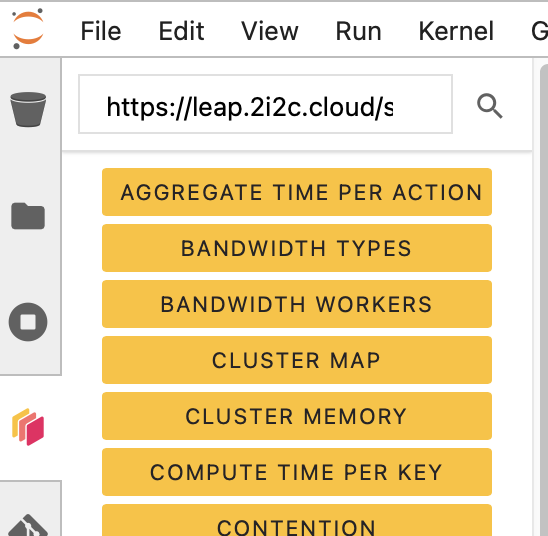

So wait, what is happening here? 

By starting a Gateway cluster, we provisioned more kubernetes nodes in the cloud which run dask and can do work!

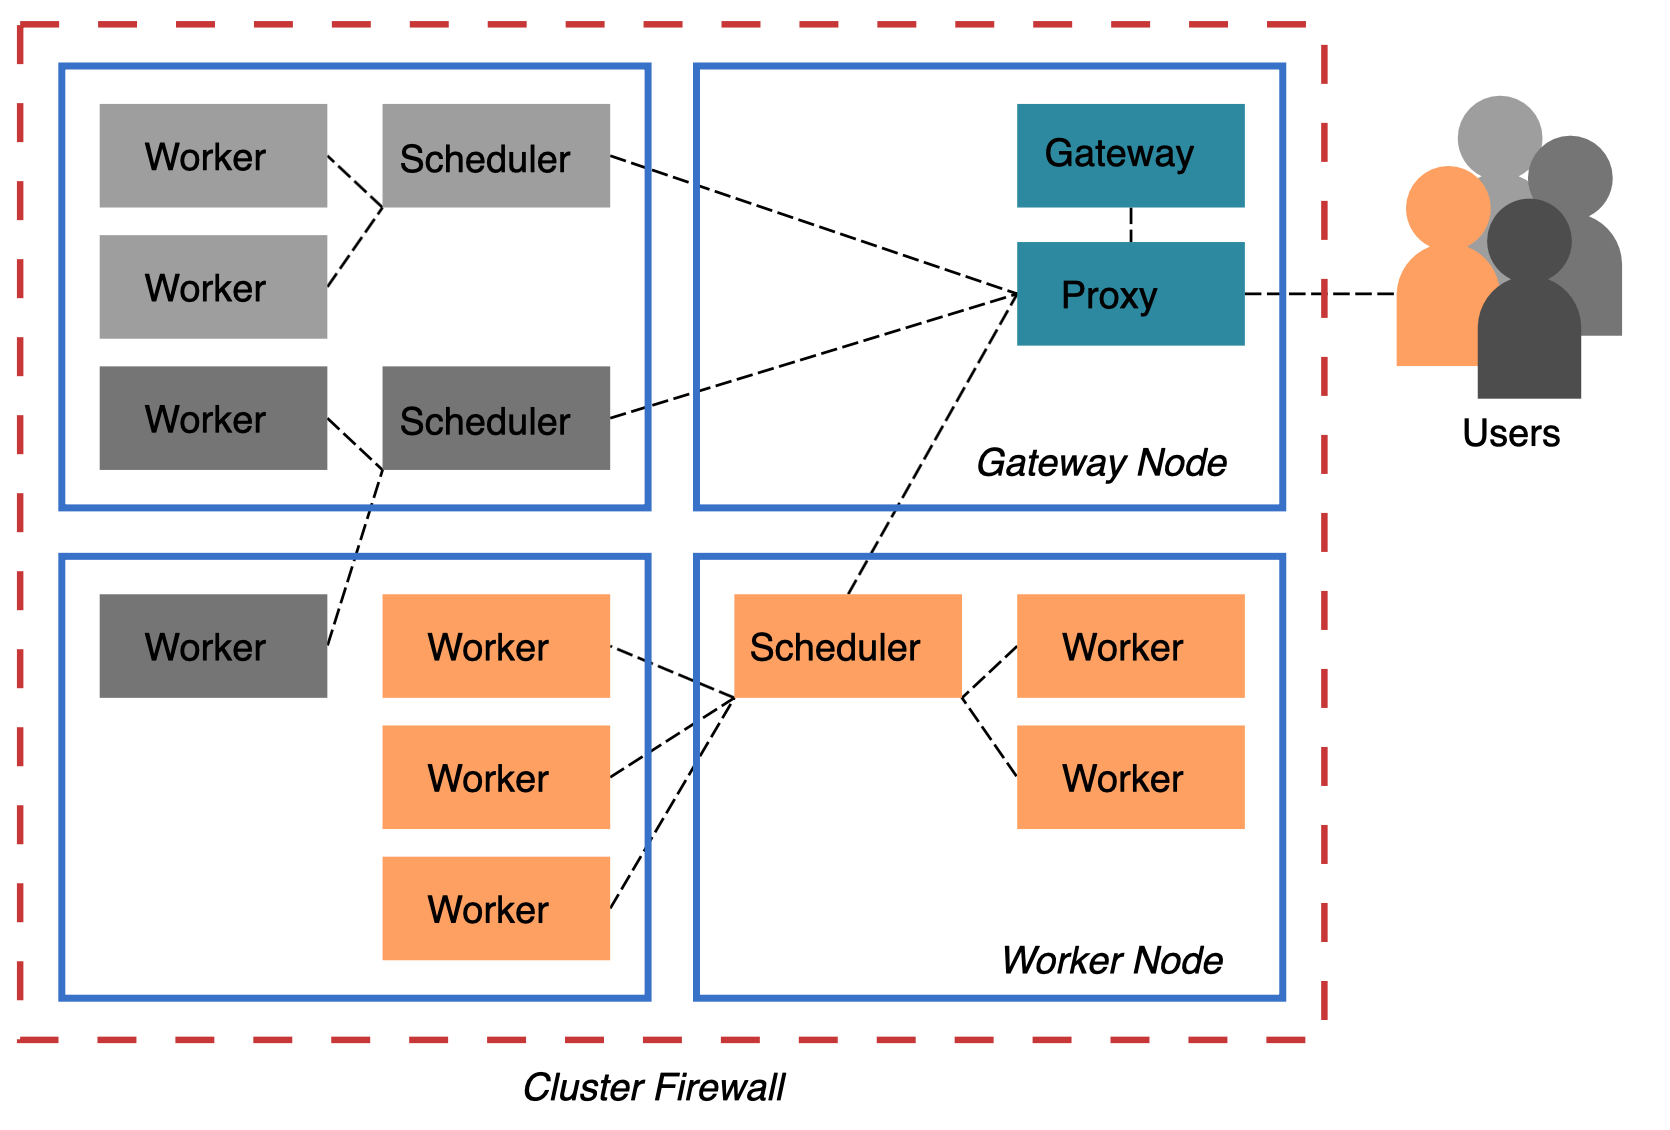

This might take a few minutes to start up, but is definitely worth it for very large computations. 

> Depending on your usecase you might get great results with a large 16 core server node already. Try it out depending on your usecase.

<div class="alert alert-success">
If you just want the fancy dashboard, but keep the computation on your server, try this:
</div>

```python
from distributed import Client
client = Client()
client
```

## How about some filtering?

Following the example in the [gcm-filters docs](https://gcm-filters.readthedocs.io/en/latest/gpu.html#filtering-on-cpus-versus-gpus).

In [ ]:
mean_small_sst_variance.plot()

Is this a meaningful result? 🤷‍♂️

Should we have weighted by the cell area? 💯

Nonetheless this should be similar to many real-world workflows, and shows the power of scalable compute for more complex analysis tasks.

> A word of caution re dask and layering many lazy computations: A common issue when layering many different opations (particularly some that require rechunking!) is that dask worker memory will blow up and the workers will die. Depending on your workflow saving/loading intermediate zarr arrays might be the most practical workaround. 

In [ ]:
# lets write the results out
mean_small_sst_variance.to_dataset(name='mean_small_sst_variance').to_zarr('gs://leap-scratch/jbusecke/demo_write.zarr')

In [ ]:
test_reload = xr.open_dataset('gs://leap-scratch/jbusecke/demo_write.zarr', engine='zarr')
test_reload

In [ ]:
mean_small_sst_variance.plot()
test_reload['mean_small_sst_variance'].plot(ls='--')

## Oh wait, my original dataset is not enough. 

I just figured out I need to look at some renalysis data 😱

But it turns out someone else has already [ingested ERA5 for us](https://github.com/google-research/arco-era5) so we can continue the ARCO awesomeness!

In [ ]:
import xarray
era5 = xarray.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    chunks={'time': 48},
    consolidated=True,
)
era5

In [ ]:
era5['2m_temperature']

In [ ]:
mean_era5 = era5['2m_temperature'].mean('time').load()

In [ ]:
mean_era5.plot(robust=True)